In [1]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [2]:
data_dir = './fruits-360_dataset/fruits-360/'

In [3]:
transform = transforms.Compose([transforms.ToTensor()])


trainset = ImageFolder(data_dir + "Training", transform=transform)

testset = ImageFolder(data_dir + "Test", transform=transform)

In [4]:
len(trainset)

67692

In [5]:
len(testset)

22688

In [6]:
classes = os.listdir(data_dir + "Training")
print(f'Total Number of Classe {len(classes)}')
print(f'Classes Names: {classes[0:30]}')

Total Number of Classe 131
Classes Names: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black']


Label (numeric): 0
Label (textual): Apple Braeburn


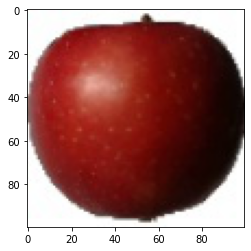

In [7]:
img, label = trainset[8]
plt.imshow(img.permute((1, 2, 0)))

print('Label (numeric):', label)
print('Label (textual):', classes[label])

Label (numeric): 10
Label (textual): Apple Red Delicious


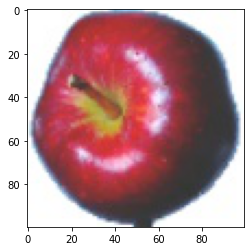

In [8]:
img, label = trainset[5000]
plt.imshow(img.permute((1, 2, 0)))

print('Label (numeric):', label)
print('Label (textual):', classes[label])

Label (numeric): 20
Label (textual): Blueberry


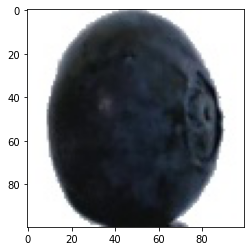

In [9]:
img, label = trainset[10000]
plt.imshow(img.permute((1, 2, 0)))

print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [10]:
transform2 = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomCrop(size=100, padding=4),
     transforms.RandomRotation(degrees=(0, 180)),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
     transforms.ToTensor(),
     ])

trainset = ImageFolder(data_dir + "Training", transform=transform2)

In [11]:
batch_size = 400

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
shuffle=False, num_workers=4)


Label (numeric): 0
Label (textual): Apple Braeburn


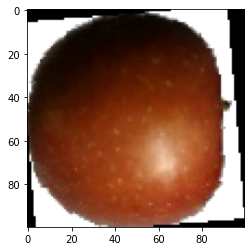

In [12]:
img, label = trainset[8]
plt.imshow(img.permute((1, 2, 0)))

print('Label (numeric):', label)
print('Label (textual):', classes[label])

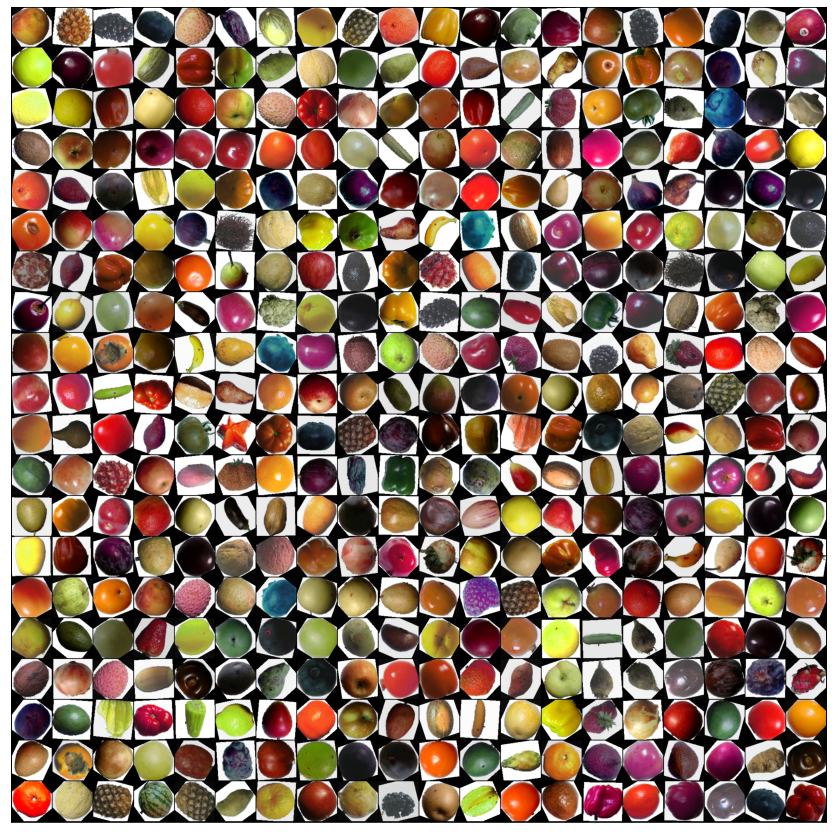

In [13]:
def show_batch(dataloader):
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

show_batch(trainloader)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Fruit360simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=2, padding=1)  # 6 x 50 x 50
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(6 * 50 * 50, 131)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = F.relu(x)
        x = self.fc1(x)
        return x


model_simple = Fruit360simple()
model_simple.cuda()

Fruit360simple(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15000, out_features=131, bias=True)
)

In [15]:
class Fruit360(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=2, padding=1)  # 16 x 50 x 50
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, padding=1) # 32 x 25 x 25
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2, padding=1) # 64 x 5 x 5
        self.norm3 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.pool2 = nn.MaxPool2d(5, 5) 
        self.fc = nn.Linear(64*5*5, 131)

    def forward(self, x):
        x = self.pool1(F.relu(self.norm1(self.conv1(x))))
        x = self.pool1(F.relu(self.norm2(self.conv2(x))))
        x = self.pool2(F.relu(self.norm3(self.conv3(x))))
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = F.relu(x)
        x = self.fc(x)
        return x


model = Fruit360()
model.cuda()

Fruit360(
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=131, bias=True)
)

In [16]:
class Fruit360CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=2, padding=1)  # 32 x 50 x 50
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, padding=1) # 64 x 25 x 25
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, padding=1) # 128 x 5 x 5
        self.norm3 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.pool2 = nn.MaxPool2d(5, 5) 
        self.fc1 = nn.Linear(128*5*5, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 131)

    def forward(self, x):
        x = self.pool1(F.relu(self.norm1(self.conv1(x))))
        x = self.pool1(F.relu(self.norm2(self.conv2(x))))
        x = self.pool2(F.relu(self.norm3(self.conv3(x))))
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = F.relu(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

model_complex = Fruit360CnnModel()
model_complex.cuda()

Fruit360CnnModel(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=131, bias=True)
)

In [17]:
import torchvision.models as models

class ResNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)     # You can change the resnet model here
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 131)          # Output classes
    
    def forward(self, x):
        return F.relu(self.network(x))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
            
model_rs = ResNetCNN()
model_rs.cuda()

ResNetCNN(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [19]:
def train(model, epoch,los):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    print('\nEpoch : %d'%epoch)
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()    
    accu=100.*correct/total
    print(f'training loss: {loss.detach()} ')
    los.append(loss.detach())
    print(f'Accuracy of the network on the train images: {accu} %')
    print('Finished Training')

In [20]:
def test(model, epoch,accuracy):
    model.eval()
    print('\nEpoch : %d'%epoch)
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accu=100.*correct/total
    accuracy.append(accu)
    
    print(f'Accuracy of the network on the 22688 test images: {accu} %')

In [21]:
models_acc = {
    'Simple': [],
    'Model': [],
    'Complex': [],
    'ResNet': [],
}

In [ ]:
los = []
accuracy = []
epochs= 10
for epoch in range(1,epochs+1): 
    train(model_simple,epoch,los)
    test(model_simple,epoch,accuracy)


In [ ]:
for i in range(epoch):
    los[i] = los[i].cpu().numpy()

In [ ]:
plt.plot(range(epoch), los)
plt.title('Loss vs. No. of epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')


In [ ]:
plt.plot(range(epoch), accuracy)
models_acc['Simple'] = accuracy
plt.title('Accuracy vs. No. of epochs')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')

In [ ]:
los = []
accuracy = []
epochs= 10
for epoch in range(1,epochs+1): 
    train(model,epoch,los)
    test(model,epoch,accuracy)

In [ ]:
for i in range(epoch):
    los[i] = los[i].cpu().numpy()

In [ ]:
plt.plot(range(epoch), los)
plt.title('Loss vs. No. of epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')


In [ ]:
plt.plot(range(epoch), accuracy)
models_acc['Model'] = accuracy
plt.title('Accuracy vs. No. of epochs')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')

In [ ]:
los = []
accuracy = []
epochs= 10
for epoch in range(1,epochs+1): 
    train(model_complex,epoch,los)
    test(model_complex,epoch,accuracy)

In [ ]:
for i in range(epoch):
    los[i] = los[i].cpu().numpy()

In [ ]:
plt.plot(range(epoch), los)
plt.title('Loss vs. No. of epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')

In [ ]:
plt.plot(range(10), accuracy)
models_acc['Complex'] = accuracy
plt.title('Accuracy vs. No. of epochs')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')

In [ ]:
los = []
accuracy = []
epochs= 10
#model_rs.freeze()

for epoch in range(1,epochs+1): 
    train(model_rs,epoch,los)
    test(model_rs,epoch,accuracy)

#model_rs.unfreeze()
# for epoch in range(1,epochs+1): 
#     train(model_rs,epoch,los)
#     test(model_rs,epoch,accuracy)



Epoch : 1
training loss: 0.8447301387786865 
Accuracy of the network on the train images: 71.09259587543579 %
Finished Training

Epoch : 1
Accuracy of the network on the 22688 test images: 88.18767358033446 %

Epoch : 2
training loss: 0.662814736366272 
Accuracy of the network on the train images: 90.4877976718076 %
Finished Training

Epoch : 2
Accuracy of the network on the 22688 test images: 91.08757312533238 %

Epoch : 3
training loss: 0.5018320679664612 
Accuracy of the network on the train images: 91.20280092182237 %
Finished Training

Epoch : 3
Accuracy of the network on the 22688 test images: 91.25155114341429 %

Epoch : 4


In [ ]:
for i in range(10):
    los[i] = los[i].cpu().numpy()

In [ ]:
plt.plot(range(10), los)
plt.title('Loss vs. No. of epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')

In [ ]:
plt.plot(range(10), accuracy)
models_acc['ResNet'] = accuracy
plt.title('Accuracy vs. No. of epochs')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')

In [ ]:
plt.plot(range(10), models_acc['Simple'],label = 'Simple')
plt.plot(range(10), models_acc['Model'],label = 'Normal')
plt.plot(range(10), models_acc['Complex'],label = 'Complex')
plt.plot(range(10), models_acc['ResNet'],label = 'ResNet34')
plt.title('Test Accuracy of Various Models')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')
plt.legend(loc='upper left',prop={'size': 7})

In [ ]:
import pickle
#save all the information in a dictionary
pickle_out = open("dict.pickle","wb")
pickle.dump(models_acc, pickle_out)
pickle_out.close()

pickle_in = open("dict.pickle","rb")
models_acc = pickle.load(pickle_in)